In [ ]:
import torch
import random
from monai.networks.nets import UNet
from monai.losses import DiceCELoss, DiceLoss
from monai.data import Dataset
from monai.transforms import Compose,ToTensord, LoadImaged, EnsureChannelFirstD, Rotate90d, Flipd, ToDeviced

In [ ]:
class FloodAreaSegmentation(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.lenght = len(data)
        self.transform = transform

    def __len__(self):
        return self.lenght

    def __getitem__(self, index):       
        return {'image': self.data[index]["image"] , 'label': self.data[index]["label"]}

In [ ]:
class DataLoader() :
    def __init__(self, dataset, batch_size=5, shuffle=True, transform = None, sides_size = 512, device = torch.device("cpu"),keep_empties = False) :
        self.dataset = dataset
        self.batch_size = batch_size
        self.transform = transform
        self.size = sides_size
        self.shuffle = True
        self.device = device
        self.keep_empties = keep_empties

    def __iter__(self):
        self.aviable_indexes = list(range(self.dataset.lenght))
        return self        

    def __next__(self):
        actual_batch_size = self.batch_size if len(self.aviable_indexes) >= self.batch_size else len(self.aviable_indexes)
        if actual_batch_size <= 0 :
            raise StopIteration() 
        if self.shuffle :
            sampled_elements = random.sample(self.aviable_indexes, actual_batch_size)
        else :
            sampled_elements = self.aviable_indexes[:actual_batch_size]
        
        batch_images = torch.zeros((actual_batch_size,3,self.size,self.size)).to(self.device)
        batch_labels = torch.zeros((actual_batch_size,1,self.size,self.size)).to(self.device)
        batch = {}
        batch["image"] = batch_images
        batch["label"] = batch_labels
        for i,element in enumerate(sampled_elements): 
            transformed =  self.transform({"image" : self.dataset[element]["image"],"label" :self.dataset[element]["label"]})
            batch["image"][i] = transformed["image"]     
            batch["label"][i] = transformed["label"]
            batch["label"][i]  = torch.where(batch["label"][i] == 255, 1,0)
            self.aviable_indexes.remove(element)
        
        if not self.keep_empties : batch = self.discard_empties(batch)
        return batch
    
    def discard_empties(self,batch : torch.Tensor):
        non_zero_indices = torch.argwhere(batch["label"].sum(dim=(1,2,3)) != 0)        
        batch_images = batch["image"][non_zero_indices.T[0]] 
        batch_labels = batch["label"][non_zero_indices.T[0]] 
        batch = {}
        batch["image"] = batch_images
        batch["label"] = batch_labels

        return batch
        

        

In [ ]:
images_path, labels_path = tuple([f"Dataset/Train/{x}" for x in ["Images","Labels"]])

train_set = {num : {
    "image" : f"{images_path}/{num}.png",
    "label" : f"{labels_path}/{num}.png"   
} for num in range(0,699)}

images_path, labels_path = tuple([f"Dataset/Test/{x}" for x in ["Images","Labels"]])

test_set = {num - 700 : {
    "image" : f"{images_path}/{num}.png",
    "label" : f"{labels_path}/{num}.png"   
} for num in range(700,1045)}


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using {device}")

In [ ]:
model = UNet(
spatial_dims=2, 
in_channels=3, 
out_channels=1,
channels=(16,32,64,128,256,512),
strides=(2,2,2,2,2),
    num_res_units=4).to(device)

model.load_state_dict(torch.load('model.pth'))



In [ ]:
train_transforms = Compose([
    LoadImaged(keys=['image','label']),
    ToTensord(keys=['image','label']),
    ToDeviced(keys=['image','label'],device=device),
    EnsureChannelFirstD(keys=['image','label']),
    Rotate90d(keys=['image','label'], k=3),
    Flipd(keys=['image','label'], spatial_axis=1),
])


In [ ]:
dataset_train = FloodAreaSegmentation(train_set, transform=train_transforms)
dataloader_train = DataLoader(dataset_train, batch_size=5, shuffle=True, transform=train_transforms)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
class MetricsEvaluator() :
    def __init__(self, y_pred, y, tresh = True) :
        if tresh : y_pred = torch.where(y_pred > 0 ,1 ,0)
        self.overlap = torch.where(y_pred == y,1,0)
        self.true_positives = torch.count_nonzero(torch.where(y == 1, self.overlap, 0))
        self.false_negatives = torch.count_nonzero(torch.where(y == 1, 1 - self.overlap, 0))
        self.false_positive = torch.count_nonzero(torch.where(y==0, 1 - self.overlap, 0)) 

    def __call__(self, metrics) :
        response = []
        for metric in metrics:
            try :
                criterion = getattr(self, metric)
                value = criterion()
                # if torch.isnan(value) : value = 0
                response.append(value)
            except :
                continue
        return response

    def dice(self) :
        metric_dict = {
            "name" : "dice",
            "value" : 2*self.true_positives/(self.false_negatives+self.false_positive + 2*self.true_positives)
        }
        return metric_dict
    
    def sensitivity(self) :
        metric_dict = {
            "name" : "sensitivity",
            "value" : self.true_positives/(self.false_negatives + self.true_positives)
        }
        return metric_dict
    
    


In [ ]:
def trainloop(model,criterion,dataloader,quiet = False, flush_memory=False) :
    model.train()    
    epoch_loss = 0
    step = 0
    for batch in dataloader:
        step += 1

        inputs, targets = batch['image'].to(device), batch['label'].to(device)        
        outputs = model(inputs)
        
        loss = criterion(outputs, targets)
        epoch_loss += loss.item()        
        if(not quiet) : print("Loss:{}".format(loss.item()))  

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        
    if flush_memory : torch.cuda.empty_cache()

    return epoch_loss/step

In [ ]:
def test(model, metrics, dataloader : DataLoader, quiet = True) :    
    model.eval()
    epoch_loss = torch.zeros(len(metrics))
    step = 0    
    for batch in dataloader :    
        step +=1
        inputs, targets = batch['image'].to(device), batch['label'].to(device)
        outputs = model(inputs)   
        evaluator = MetricsEvaluator(outputs,targets)
        for i,metric in enumerate(evaluator(metrics)) : 
            metric_name = metric["name"]
            loss = metric["value"]
            if(not quiet) : print(f"{metric_name} : {loss.item()}")
            epoch_loss[i] += loss.item()

    metric_scores = {metric:0 for metric in metrics}
    for i,metric in enumerate(metrics) :        
        metric_scores[metric] = epoch_loss[i].item()/step

    return metric_scores

In [ ]:
num_epochs = 1
criterion = DiceLoss(sigmoid=True).to(device)
metrics = ["dice","sensitivity"]

train_losses = []
test_metrics = []
     
for epoch in range(num_epochs):   
    loss = trainloop(model,criterion,dataloader_train, quiet=True)
    train_losses.append(loss)
    torch.cuda.empty_cache()
    scores = test(model,metrics,dataloader_train,quiet= True)
    test_metrics.append(scores)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}')
    for score in scores.items() :
        print(f'Epoch {epoch+1}/{num_epochs}, Test {score[0]} : {score[1]}')

torch.save(model.state_dict(), 'model.pth')

In [ ]:
# print(train_losses)
print(test_metrics)

In [83]:
from matplotlib import pyplot as plt
def display_segmentation(model,dataset : FloodAreaSegmentation,id, reduction = "treshold") :
    input_dict = dataset.transform(dataset[id])    
    model.eval()
    img = torch.unsqueeze(input_dict["image"],dim=0)
    img_r = img[0,0,:,:]
    img_g = img[0,1,:,:]
    img_b = img[0,2,:,:]
    img_rgb = torch.stack([img_r,img_g,img_b],dim=2).to(torch.int32)    

    output = model(img)
    if reduction == "treshold" : out_treshold = torch.where(output>0.5,1,0)
    else : out_treshold = torch.sigmoid(output)

    lab = (input_dict["label"][0,:,:].cpu()).to(torch.int32)

    plt.subplot(1,3,1)
    plt.imshow(lab)
    plt.title('Correct',fontsize=12)
    plt.subplot(1,3,2)
    plt.imshow(img_rgb.detach().cpu())
    plt.subplot(1,3,3)   
    plt.imshow(out_treshold.detach().cpu()[0,0,:,:])
    plt.title('Predicted',fontsize=12)

In [ ]:
dataset_test = FloodAreaSegmentation(test_set,transform=train_transforms)
dataloader_test = DataLoader(dataset_test,25,transform=train_transforms,sides_size=512)

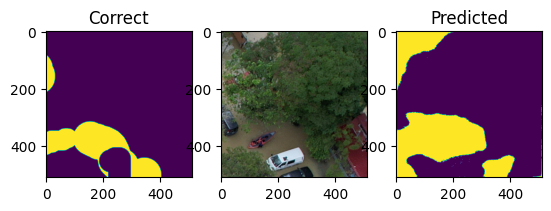

In [84]:
display_segmentation(model,dataset_test,175);

In [ ]:
metrics = ["dice","sensitivity"]
test(model,metrics,dataloader_test,quiet = True)

In [ ]:
plt.plot(train_losses)